In [4]:
import sys, os
import math, random
import datetime

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset

import torchmetrics

from PIL import Image
import matplotlib.pyplot as plt


c:\Users\umari\anaconda3\envs\DL38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading the dataset + setting the labels

In [5]:
class_labels = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 
                'bus', 'car', 'cat', 'chair', 'cow',
                'diningtable', 'dog', 'horse', 'motorbike', 'person',
                'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

In [6]:
class transformLabel(object):

    def __init__(self, classes):
        self.classes = classes

    def __call__(self, metadata, num_classes=20):
        label = torch.zeros(num_classes)
        for obj in metadata['annotation']['object']:
            label[self.classes.index(obj['name'])] = 1

        return label


In [7]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225] # mean and std found from PapersWithCode

transformTrain = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter((0.6, 1.4), (0.6, 1.4), (0.6, 1.4), (-0.1, 0.1)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomGrayscale(0.2),
    transforms.RandomAffine(degrees=0, scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
]
)

transformVal = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
]
)

In [8]:
VOC_train = datasets.VOCDetection('data/trainval/', 
                                year='2012', 
                                image_set='train', 
                                download=False, 
                                transform=transformTrain,
                                target_transform=transformLabel(class_labels),
                                )


VOC_val = datasets.VOCDetection('data/trainval/', 
                                year='2012', 
                                image_set='val', 
                                download=False, 
                                transform=transformVal,
                                target_transform=transformLabel(class_labels)
                                )

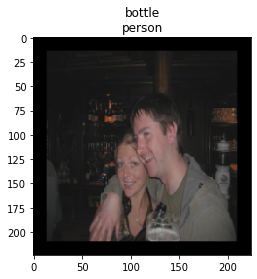

In [9]:
img_, lbl_ = VOC_train[random.randint(0, len(VOC_train))]

lbl = torch.where(lbl_==1)[0]
label = ""
for idx, num in enumerate(lbl):
    if idx!=0:
        label += "\n"
    label += class_labels[int(num)]

plt.figure()
plt.imshow(img_.permute(1,2,0)*torch.tensor(std) + torch.tensor(mean))
plt.title(label)
plt.show()

## Building architecture

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


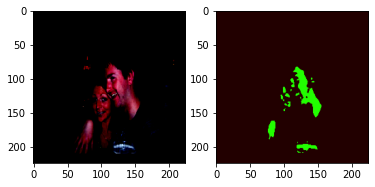

In [10]:
# checking seperable convolutions...
n = 3
conv = nn.Conv2d(n, n, kernel_size=3, padding=1, groups=n,)
conv.weight.requires_grad=False
conv.weight[0,:,:,:] = torch.nn.Parameter(0*torch.ones((1,3,3)))
conv.weight[1,:,:,:] = torch.nn.Parameter(5*torch.ones((1,3,3)))
conv.weight[2,:,:,:] = torch.nn.Parameter(0*torch.ones((1,3,3)))


img_convd = conv(img_)
plt.subplot(121)
plt.imshow(np.transpose(img_,(1,2,0)))
plt.subplot(122)
plt.imshow(np.transpose(img_convd.detach().numpy(),(1,2,0)))

### separable convolution blocks and squeeze-excitation net

Squeeze and excitation layer intuitions: https://towardsdatascience.com/squeeze-and-excitation-networks-9ef5e71eacd7

Seperable convolution block: https://arxiv.org/abs/2204.01697

Transformer encoder: https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder

In [11]:
class SqueezeExcite(nn.Module): 

    def __init__(self, c_in, r=2):
        
        super().__init__()

        c_mid = round(c_in/r)
        self.squeeze = nn.Linear(c_in, c_mid)
        self.excite = nn.Linear(c_mid, c_in)

    def forward(self, x):

        x_in = x

        x = torch.mean(torch.flatten(x, -2, -1), dim=-1) # GAP
        x = torch.relu(self.squeeze(x))
        x = torch.sigmoid(self.excite(x))
        x = x.unsqueeze(-1).unsqueeze(-1)
        x = x_in*(x + 1)

        return x


class SepBlock(nn.Module): # similar to MBConv block found in max-vit!

    def __init__(self, c_in=3, c_out=3, res=False, project=False, SE=False, reduce=False):

        super().__init__()
            
        self.res = res
        self.SE = SE
        self.reduce = reduce
        
        self.project = False if c_in == c_out else True

        depth_stride=2 if reduce else 1

        self.conv_depth = nn.Conv2d(c_in, c_in, kernel_size=3, stride=depth_stride, padding=1, groups=c_in)
        self.conv_point = nn.Conv2d(c_in, c_in, kernel_size=1, padding=0, groups=1) 
        self.conv_project = nn.Conv2d(c_in, c_out, kernel_size=1, padding=0, groups=1) 
        self.squeeze_excite = SqueezeExcite(c_in)
        
        self.batchnorm = nn.BatchNorm2d(num_features=c_out)

    def forward(self, x):

        x_in = x
        x = self.conv_point(x)                                          # 1x1 pointwise
        x = torch.relu(self.conv_depth(x))                              # 3x3 depthwise

        if self.SE:                                                     
            x = self.squeeze_excite(x)                                  # squeeze-excitation
        
        x = torch.relu(self.conv_point(x))                              # 1x1 pointwise

        if self.res:
            x_in = torch.max_pool2d(x_in, 2) if self.reduce else x_in
            x = x + x_in                                                # residual
            
        if self.project:
            x = torch.relu(self.batchnorm(self.conv_project(x)))     # project to c_out dimensions

        
        # print('block done:', x.shape)
        
        return x


In [12]:
A = torch.rand(size=(32, 3, 56, 56))

sep = SepBlock(c_in=3, c_out=6, res=True, SE=True, reduce=True)
B = sep(A)

A.shape, B.shape

(torch.Size([32, 3, 56, 56]), torch.Size([32, 6, 28, 28]))

### Full network

In [13]:
class SepNet(nn.Module):

    def __init__(self, classes=20, c0=3, c1=32, c2=64, c_SC=512, SC_blocks=6):
        super().__init__()
        
        self.c_SC = c_SC

        self.conv1 = nn.Conv2d(c0, c1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(c1, c2, kernel_size=3, padding=1)
        self.batchnorm = nn.BatchNorm2d(num_features=c2)

        # add SepBlocks, reducing and projecting to higher-D alternatively. 56x56x64 --> 7x7x512
        proj_steps = int(math.log(c_SC//c2, 2))
        layer_step = SC_blocks / proj_steps

        SC_list = []

        c_in = c2
        n=1
        for i in range(SC_blocks):
            if round(n*layer_step)==i+1: # downsample and project at each layer_step [eg: i=1,3,5 for N=6]
                n+=1 
                c_out = 2*c_in
                red = True 
            else:
                c_out=c_in
                red = False
            
            SC_list.append(SepBlock(c_in=c_in, c_out=c_out, res=True, SE=True, reduce=red))
            
            c_in = c_out

        if c_out != c_SC:
            print("somethings wrong!")

        # print(SC_list)
        self.SClayers = nn.Sequential(*SC_list)
        self.ViTlayer1 = nn.TransformerEncoderLayer(d_model=c_SC, nhead=8, dim_feedforward=c_SC*2, batch_first=True)
        self.ViTlayer2 = nn.TransformerEncoderLayer(d_model=c_SC, nhead=8, dim_feedforward=c_SC*2, batch_first=True, norm_first=True)

        self.classifier = nn.Linear(c_SC, classes)

    def forward(self, x):
        
        x = torch.max_pool2d(torch.relu(self.conv1(x)), 2)
        x = torch.max_pool2d(torch.relu(self.batchnorm(self.conv2(x))), 2)

        x = self.SClayers(x)

        h = x.shape[-1]

        x = x.view(-1, self.c_SC, h*h)

        # x = x.permute(0, 2, 1)
        # x = self.ViTlayer1(x)
        # x = self.ViTlayer2(x)
        # x = x.permute(0, 2, 1)

        x = torch.mean(x, dim=-1)

        x = torch.sigmoid(self.classifier(x)).squeeze(0)

        return x


In [14]:
A = torch.rand(size=(32, 3, 224, 224))

net_temp = SepNet(SC_blocks=8)
B = net_temp(A)

print('in:',A.shape, '\nout:',B.shape)


in: torch.Size([32, 3, 224, 224]) 
out: torch.Size([32, 20])


## Training!!

In [20]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [14]:
def Trainer(net, epochs, loss_fn, optimiser, train_loader, val_loader):

    for epoch in range(1, epochs + 1):

        loss_train = 0.0
        net.train()

        for imgs, labels in train_loader:

            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = net(imgs)

            # print(labels.shape, outputs.shape)
            loss = loss_fn(outputs, labels)

            # l2_lambda = 0.0001
            # l2_norm = sum(p.pow(2.0).sum() for p in net.parameters())**0.5 # L2 reg for all the weights

            # loss = loss + l2_lambda*l2_norm

            optimiser.zero_grad() 
            loss.backward()
            optimiser.step()

            loss_train += loss.item()

        # validations
        loss_val = 0.0
        net.eval()
        with torch.no_grad():
            for imgs, labels in val_loader:

                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = net(imgs)

                loss = loss_fn(outputs, labels)
                loss_val += loss.item()
            
                
            if epoch == 1 or epoch % 4 == 0:
                
                dt = datetime.datetime.now()  

                print('{} Epoch {}, Training loss {}, val loss {}'.format(
                    dt, epoch,
                    round(loss_train / len(train_loader), 4),
                    round(loss_val / len(val_loader), 4),
                ))


                path = os.path.join(os.getcwd(), 'checkpoints', 'SepNet_ep_' + str(epoch) + '_checkpoint.pt')
                # print(path)
                torch.save({ 
                    'epoch': epoch,
                    'model': net.state_dict(),
                    'optimizer': optimiser.state_dict()}, path)

In [30]:
net = SepNet().to(device=device)
optimiser = optim.Adam(net.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()

BS = 64

train_loader = DataLoader(VOC_train, batch_size=BS,shuffle=True)
val_loader = DataLoader(VOC_val, batch_size=BS, shuffle=False)

toy_train = Subset(VOC_train, list(range(BS))) # 5 batches of data!
toy_val = Subset(VOC_val, list(range(BS)))

toy_train_loader = DataLoader(toy_train, batch_size=BS,shuffle=True)
toy_val_loader = DataLoader(toy_val, batch_size=BS,shuffle=False)

note: sanity check with batch=2 works... something is up - without transformer it works much better! whyyyy

In [19]:
Trainer(net=net, epochs=20, 
    loss_fn=loss_fn, optimiser=optimiser, 
    train_loader=train_loader, val_loader=val_loader)

2022-06-13 00:01:42.333731 Epoch 1, Training loss 0.2638, val loss 0.229
2022-06-13 00:07:03.490768 Epoch 4, Training loss 0.2083, val loss 0.2151
2022-06-13 00:14:24.260887 Epoch 8, Training loss 0.1912, val loss 0.1949
2022-06-13 00:22:11.102675 Epoch 12, Training loss 0.178, val loss 0.1956
2022-06-13 00:29:46.886890 Epoch 16, Training loss 0.1666, val loss 0.1756
2022-06-13 00:37:22.794892 Epoch 20, Training loss 0.1574, val loss 0.1779


## Loading and evaluating

### accuracy metric: MAP

We have +ve classes and -ve classes. We take a measure of many logits we have to go down for all the +ve ground truth classes to be seen. Precision is standard precision term.

Normal accuracy seems to be a bit unfair.... for example if there are average of 2 objects per image, then 90% of the time it will be correct in predicting even if the model outputs all zeros.

In [31]:

def AvgPrecision(outputs, targets):

    AP = torch.zeros(outputs.shape[0])

    for n in range(outputs.shape[0]):
        out = outputs[n,:]
        # print(out)
        target = targets[n,:]

        _, idxs = torch.sort(out, descending=True)
        idx_targets = torch.where(target==1)[0]

        # print(idx_targets)

        pos = 0
        p = []
        for idx, num in enumerate(idxs):
            if num in idx_targets:
                pos +=1
                p.append(pos / (idx+1))
        
        AP[n] = sum(p) / len(p)

    return AP


### loading the pretrained model

In [32]:
trained_model = SepNet()
optimiser = optim.Adam(trained_model.parameters(), lr=1e-3)
epoch=20

path = os.path.join(os.getcwd(), 'checkpoints', 'SepNet_ep_' + str(epoch) + '_checkpoint.pt')

checkpoint = torch.load(path)
trained_model.load_state_dict(checkpoint['model'])
optimiser.load_state_dict(checkpoint['optimizer'])
epoch = checkpoint['epoch']

trained_model.eval()


SepNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (SClayers): Sequential(
    (0): SepBlock(
      (conv_depth): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
      (conv_point): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (conv_project): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_excite): SqueezeExcite(
        (squeeze): Linear(in_features=64, out_features=32, bias=True)
        (excite): Linear(in_features=32, out_features=64, bias=True)
      )
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): SepBlock(
      (conv_depth): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64)
      (conv_point): Conv2d(64, 64, kernel_size=(1, 1)

In [48]:
def Evaluate(net, val_loader):

    with torch.no_grad():

        acc = 0.0
        MAP = 0.0

        count=0

        for imgs, labels in val_loader:

            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = net(imgs)

            MAP_batch = 100*torch.mean(AvgPrecision(outputs, labels))

            # print(MAP_batch)

            MAP += MAP_batch

            out = torch.zeros_like(outputs)
            out[outputs>0.5]=1

            out = out.view(-1,)
            labels = labels.view(-1,)

            acc += 100*sum(out==labels) / len(labels)
            
            count+=1
            # print(out.shape, labels.shape)

        acc = round(float(acc / count), 2)
        MAP = round(float(MAP / count), 2)

        print('accuracy (with threshold 0.5):', float(acc),'%')
        print('MAP:', float(MAP),'%')


In [49]:
trained_model.to(device=device)
val_loader = DataLoader(VOC_val, batch_size=128, shuffle=False)

Evaluate(trained_model, val_loader=val_loader)

accuracy (with threshold 0.5): 93.2 %
MAP: 65.88 %


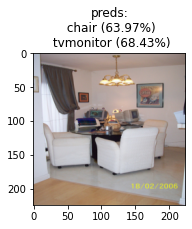

In [73]:
img_, lbl_ = VOC_val[random.randint(0, len(VOC_val))]

logits = trained_model(img_.unsqueeze(0).to(device=device)) 

lbl = torch.where(lbl_==1)[0]
label = "preds:\n "
for idx, num in enumerate(lbl):
    if idx!=0:
        label += "\n "
    label += class_labels[int(num)] + ' (' + str(round(float(100*logits[int(num)]), 2)) + '%)'

plt.figure()
plt.subplot(121)
plt.imshow(img_.permute(1,2,0)*torch.tensor(std) + torch.tensor(mean))
plt.title(label)
plt.show()
